$
\def\D{\mathcal{D}}
\def\ipar{m}
\def\R{\mathbb{R}}
\def\del{\partial}
\def\vec{\bf}
\def\priorm{\mu_0}
\def\C{\mathcal{C}}
\def\Acal{\mathcal{A}}
\def\postm{\mu_{\rm{post}}}
\def\iparpost{\ipar_\text{post}}
\def\obs{\vec{d}} 
\def\yobs{\obs^{\text{obs}}}
\def\obsop{\mathcal{B}}
\def\dd{\vec{\bar{d}}}
\def\iFF{\mathcal{F}}
\def\iFFadj{\mathcal{F}^*}
\def\ncov{\Gamma_{\mathrm{noise}}}
$
# Example: Bayesian initial condition inversion in an advection-diffusion problem 

In this example we tackle the problem of quantifying the uncertainty in the solution of an inverse problem governed by a parabolic PDE via the Bayesian inference framework. The underlying PDE is a time-dependent advection-diffusion equation in which we seek to infer an unknown initial condition from spatio-temporal point measurements.

### The Bayesian inverse problem:

Following the Bayesian framework, we utilize 
a Gaussian prior measure $\priorm = \mathcal{N}(\ipar_0,\C_0)$,
with $\C_0=\Acal^{-2}$ where $\Acal$ is an elliptic differential operator as 
described in the PoissonBayesian example, and use an additive
Gaussian noise model. Therefore, the solution of the Bayesian inverse
problem is the posterior measure, $\postm = \mathcal{N}(\iparpost,\C_\text{post})$ with
$\iparpost$ and $\C_\text{post}$.

- The posterior mean $\iparpost$ is characterized as the minimizer of

$$
\begin{aligned}
& \mathcal{J}(\ipar) :=
  \frac{1}{2} \left\| \mathcal{B}u(\ipar) -\obs  \right\|^2_{\ncov^{-1}}
  + \frac 12 \left\| \Acal(\ipar - \ipar_0 \right)\|^2_{L^2(\D)},
\end{aligned}
$$

which can also be interpreted as the regularized functional to be
minimized in deterministic inversion. The observation operator $\mathcal{B}$ extracts the values of the forward solution $u$ on a set of
locations $\{\vec{x}_1, \ldots, \vec{x}_n\} \subset \D$ at
times $\{t_1, \ldots, t_N\} \subset [0, T]$.

- The posterior covariance $\C_{\text{post}}$ is the inverse of the Hessian of $\mathcal{J}(\ipar)$, i.e.,

$$
\C_{\text{post}} = (\iFFadj \ncov^{-1} \iFF + \C_0^{-1})^{-1}.
$$


### The forward problem:

The PDE in the parameter-to-observable map $\iFF$ models diffusive transport
in a domain $\D \subset \R^d$ ($d \in \{2, 3\}$):

$$
\begin{split}
u_t - \kappa\Delta u + \bf{v} \cdot \nabla u &= 0     & \quad \text{in } \D\times(0,T),\\
                                 u(\cdot, 0) &= \ipar & \quad \text{in } \D,\\
                \kappa \nabla u\cdot \vec{n} &= 0     & \quad \text{on } \partial\D \times (0,T).
\end{split}
$$

Here, $\kappa > 0$ is the diffusion coefficient and $T > 0$ is the final
time. The velocity field
$\vec{v}$ is computed by solving the following steady-state
Navier-Stokes equation with the side walls driving the flow:

$$
\begin{aligned}
- \frac{1}{\operatorname{Re}} \Delta \bf{v} + \nabla q + \bf{v} \cdot \nabla \bf{v} &= 0 &\quad&\text{ in }\D,\\
\nabla \cdot \bf{v} &= 0 &&\text{ in }\D,\\
\bf{v} &= \bf{g} &&\text{ on } \partial\D.
\end{aligned}
$$

Here, $q$ is pressure, $\text{Re}$ is the Reynolds number. The Dirichlet boundary data
$\vec{g} \in \R^d$ is given by 
$\vec{g} = \vec{e}_2$ on the left wall of the domain, 
$\vec{g}=-\vec{e}_2$ on the right wall,  and $\vec{g} = \vec{0}$ everywhere else.

### The adjoint problem:

$$
\begin{aligned}
-p_t - \nabla \cdot (p \vec{v}) - \kappa \Delta p  &= -\obsop^* (\obsop u - \obs) & \quad &\text{ in } \D\times (0,T),\\
                                      p(\cdot, T) &= 0             &       &\text{ in } \D,\\ 
(\vec{v}p+\kappa\nabla p)\cdot \vec{n}            &= 0             &       &\text{ on } \partial\D\times (0,T).
\end{aligned}
$$

## 1. Load modules

In [1]:
from __future__ import absolute_import, division, print_function
import dolfin as dl
import math
import numpy as np
import matplotlib.pyplot as plt
import os
%matplotlib inline
import sys

sys.path.append( os.environ.get('HIPPYLIB_BASE_DIR', "../") )
sys.path.append( os.environ.get('HIPPYLIB_BASE_DIR', "..") + "/applications/ad_diff/" )
sys.path.append( "../" )
from hippylib import *

sys.path.append( "../applications/ad_diff/" )
from model_ad_diff import TimeDependentAD

import logging
logging.getLogger('FFC').setLevel(logging.WARNING)
logging.getLogger('UFL').setLevel(logging.WARNING)
dl.set_log_active(False)
np.random.seed(1)

## 2. Construct the velocity field

In [2]:
def v_boundary(x,on_boundary):
    return on_boundary

def q_boundary(x,on_boundary):
    return x[0] < dl.DOLFIN_EPS and x[1] < dl.DOLFIN_EPS
        
def computeVelocityField(mesh):
    Xh = dl.VectorFunctionSpace(mesh,'Lagrange', 2)
    Wh = dl.FunctionSpace(mesh, 'Lagrange', 1)
    if dlversion() <= (1,6,0):
        XW = dl.MixedFunctionSpace([Xh, Wh])
    else:
        mixed_element = dl.MixedElement([Xh.ufl_element(), Wh.ufl_element()])
        XW = dl.FunctionSpace(mesh, mixed_element)

    Re = 1e2
    # set boundary conditions
    g = dl.Expression(('0.0','(x[0] < 1e-14) - (x[0] > 1 - 1e-14)'), degree=1)
    bc1 = dl.DirichletBC(XW.sub(0), g, v_boundary)
    
    bc2 = dl.DirichletBC(XW.sub(1), dl.Constant(0), q_boundary, 'pointwise')
    
    bcs = [bc1, bc2]
    
    vq = dl.Function(XW)
    (v,q) = dl.split(vq)
    (v_test, q_test) = dl.TestFunctions (XW)
    
    def strain(v):
        return dl.sym(dl.nabla_grad(v))
    
    F = ( (2./Re)*dl.inner(strain(v),strain(v_test))+ dl.inner (dl.nabla_grad(v)*v, v_test)
           - (q * dl.div(v_test)) + ( dl.div(v) * q_test) ) * dl.dx
           
    dl.solve(F == 0, vq, bcs, solver_parameters={"newton_solver":
                                         {"relative_tolerance":1e-4, "maximum_iterations":100}})
    
    plt.figure(figsize=(15,5))
    vh = dl.project(v,Xh)
    qh = dl.project(q,Wh)
    nb.plot(nb.coarsen_v(vh), subplot_loc=121,mytitle="Velocity")
    nb.plot(qh, subplot_loc=122,mytitle="Pressure")
    plt.show()
        
    return v

## 3. Set up the mesh and finite element spaces

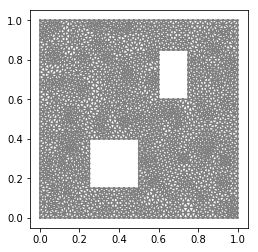

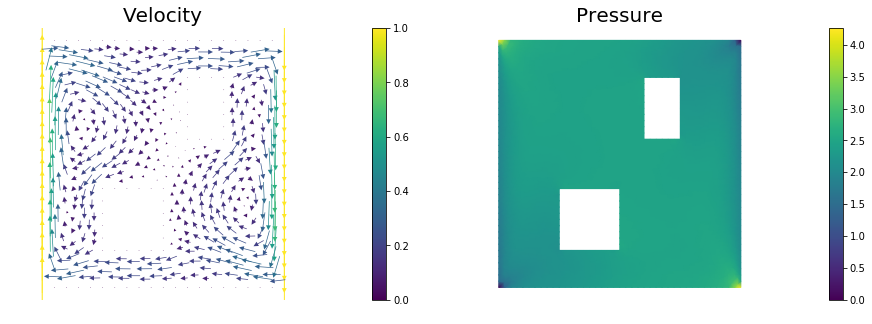

Number of dofs: 7863
done with initialization on identity vectors


In [3]:
mesh = dl.refine(dl.Mesh("ad_20.xml"))
dl.plot(mesh)
wind_velocity = computeVelocityField(mesh)
Vh = dl.FunctionSpace(mesh, "Lagrange", 2)
print("Number of dofs: {0}".format( Vh.dim() ) )

u = dl.TrialFunction(Vh)
v = dl.TestFunction(Vh)

a = dl.inner(u,v)*dl.dx
Identity = dl.assemble(a)
LUSolver = dl.assemble(a)
identity_vectors = [dl.Function(Vh) for i in range(Identity.array().shape[0])]
idt = np.identity(Identity.array().shape[0])
for i in range(Identity.array().shape[0]):
    identity_vectors[i].vector().set_local(idt[:,i])
LUSolver_vectors = [dl.Function(Vh) for i in range(LUSolver.array().shape[0])]
# # PHolder_vecto
# # rs  = [dl.Function(Vh) for i in range(PHolder.array().shape[0])]
# [identity_vectors[i].vector().set_local(Identity.array()[i]) for i in range(Identity.array().shape[0])]
# [LUSolver_vectors[i].vector().set_local(LUSolver.array()[i]) for i in range(LUSolver.array().shape[0])]
# # [ PHolder_vectors[i].vector().set_local(PHolder.array()[i])  for i in range(PHolder.array().shape[0])]

print('done with initialization on identity vectors')


## 4. Set up model (prior, true/proposed initial condition)

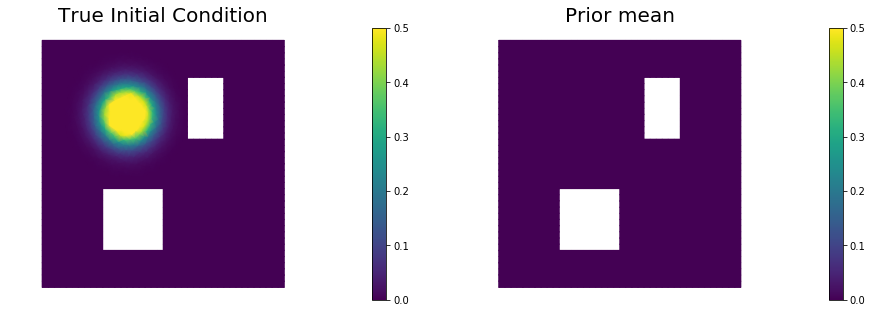

In [4]:
gamma = 1
delta = 8
prior = BiLaplacianPrior(Vh, gamma, delta)

prior.mean = dl.interpolate(dl.Constant(0.0), Vh).vector()
true_initial_condition = dl.interpolate(dl.Expression('min(0.5,exp(-100*(pow(x[0]-0.35,2) +  pow(x[1]-0.7,2))))', degree=5), Vh).vector()
problem = TimeDependentAD(mesh, [Vh,Vh,Vh], 0., 5., .1, .25, wind_velocity, True, prior)

objs = [dl.Function(Vh,true_initial_condition),
        dl.Function(Vh,prior.mean)]

mytitles = ["True Initial Condition", "Prior mean"]
nb.multi1_plot(objs, mytitles)
plt.show()

## 5. Generate the synthetic observations

In [7]:
observe_noise_std_dev = 0.01

utrue = problem.generate_vector(STATE)
x = [utrue, true_initial_condition, None]

ntargets = 80
ndim = 2
n_targets_created = 0
targets = []
while n_targets_created < ntargets:
    target = np.random.uniform(0.05,0.95, ndim )
    
    box1 = 0.2 < target[0] < 0.6 and 0.15 < target[1] < 0.5
    #box2 = target[0] >= 0.55 and target[1] >= 0.55 and target[0] <=0.9 and target[1] <=0.9 
    box2 = 0.55 < target[0] < 0.85 and 0.55 < target[1] < 0.9
    #     if not box1 and not box2:
    if not box1 and not box2:
        n_targets_created += 1
        targets.append(target)
targets = np.array(targets)

misfit = PointwiseStateObservation(Vh, targets)

MAX = misfit.d.norm("linf")
misfit.noise_variance = observe_noise_std_dev * observe_noise_std_dev
misfitds = []



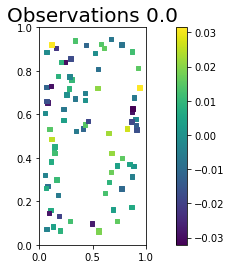

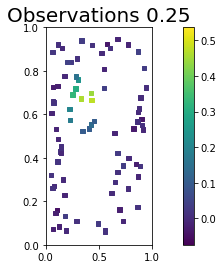

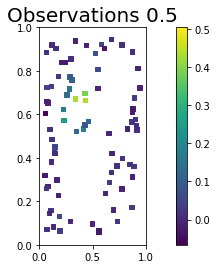

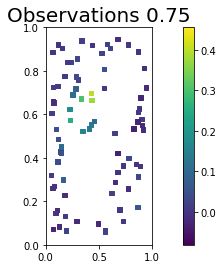

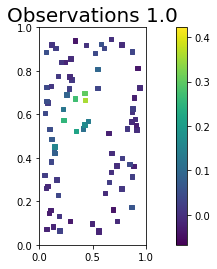

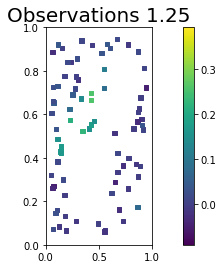

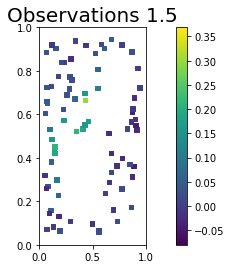

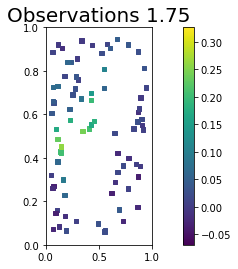

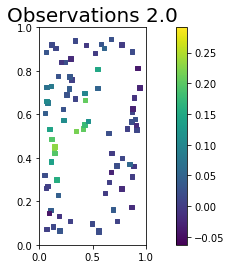

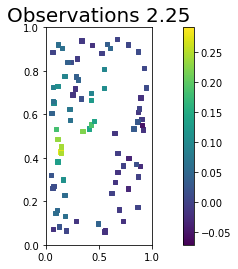

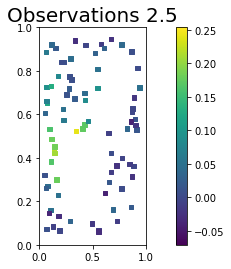

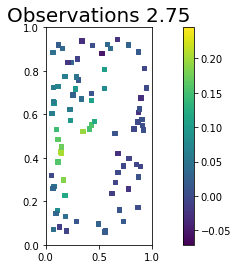

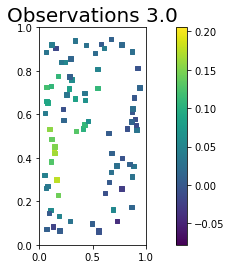

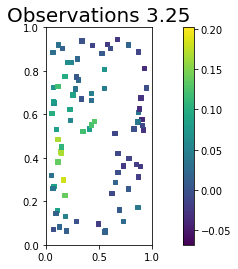

In [ ]:
# Only care about this case of utrue:
misfitds = []

process_noise_std_dev = 0.02


for i in range(len(utrue.times)):
    problem.solveFwd(x[STATE], x, 1e-9, process_noise_std_dev=process_noise_std_dev)
    problem.ud.copy(utrue)
    parRandom.normal_perturb(process_noise_std_dev, problem.ud)
#     MAX = utrue.norm("linf","linf")
#     noise_std_dev = rel_noise * MAX    
    
#     parRandom.normal_perturb(noise_std_dev, problem.ud)
    #problem.noise_variance = noise_std_dev*noise_std_dev
    misfit.B.mult(problem.ud.data[i], misfit.d)
    
    np_misfit_d = misfit.d.get_local() 
#     for diter in range(len(np_misfit_d)):
#         np_misfit_d[diter] += np.random.normal(0, observe_noise_std_dev)
#     misfit.d.set_local(np_misfit_d)
    misfitds.append(misfit.d)

    # add observation noise to misfit.d i.i.d np.radnom.normal
    
#     misfitds.append(misfit.d)
    vmax = max( max(utrue.data[i]), misfit.d.max() )
    vmin = min( min(utrue.data[i]), misfit.d.min() )    
    nb.plot_pts(targets, misfitds[i], mytitle="Observations " + str(utrue.times[i]), subplot_loc=122, vmin=vmin, vmax=vmax)    
    plt.show()
nb.show_solution(Vh, true_initial_condition, problem.ud, "Solution", times = [0.0, 0.4, 1.0, 2.0, 3.0,4.0,5.0,6.0,7.0])



## 6. Test the gradient and the Hessian of the cost (negative log posterior)

In [ ]:
print(utrue)
print(problem.ud)

In [ ]:
a0 = true_initial_condition.copy()
_ = modelVerify(problem, a0, 1e-12, is_quadratic=True)

## 7. Evaluate the gradient

In [ ]:
[u,a,p] = problem.generate_vector()
problem.solveFwd(u, [u,a,p], 1e-12)
problem.solveAdj(p, [u,a,p], 1e-12)
mg = problem.generate_vector(PARAMETER)
grad_norm = problem.evalGradientParameter([u,a,p], mg)
        
print("(g,g) = ", grad_norm)

## 8. The Gaussian approximation of the posterior

In [ ]:
H = ReducedHessian(problem, 1e-12, misfit_only=True) 

k = 80
p = 20
print( "Single Pass Algorithm. Requested eigenvectors: {0}; Oversampling {1}.".format(k,p) )
Omega = MultiVector(x[PARAMETER], k+p)
parRandom.normal(1., Omega)
lmbda, V = singlePassG(H, prior.R, prior.Rsolver, Omega, k)


posterior = GaussianLRPosterior( prior, lmbda, V )
plt.plot(range(0,k), lmbda, 'b*', range(0,k+1), np.ones(k+1), '-r')
plt.yscale('log')
plt.xlabel('number')
plt.ylabel('eigenvalue')

nb.plot_eigenvectors(Vh, V, mytitle="Eigenvector", which=[0,1,2,5,10,20,30,45,60])


Construct covariance and mean ...hahaha
Form K and others

In [7]:
def np_Vec_to_la_Vec(np_vec):
    holder = dl.Function(Vh)
    holder.vector().set_local(np_vec)
    return holder.vector()

def la_Mat_to_np_Vec(la_vec):
    return la_vec.array()

In [8]:
# for i in range(len(identity_vectors)):
#     identity_vectors[i].vector().zero()
#     identity_vectors[i].vector()[i] = 1
#     identity_vectors[i].vector().set_local(identity_vectors[i].vector().get_local())

curMean = np.zeros(Vh.dim())

P = np.zeros((len(identity_vectors), len(identity_vectors)))

# for i in range(len(identity_vectors)):
#     prior.R.mult(identity_vectors[i].vector(),PHolder_vectors[i].vector())
#     P[:,i] = PHolder_vectors[i].vector()

# Q = process_noise_std_dev*process_noise_std_dev*np.identity(Vh.dim())
# R = observe_noise_std_dev*observe_noise_std_dev*np.identity(Vh.dim())
Bops = misfit.B.array()



In [9]:

iters = len(misfitds)
print(iters)


21


In [10]:
## Construct F, the transition operator

np_LUSolver = np.zeros((Vh.dim(), Vh.dim()))
Bops = misfit.B.array()
for i in range(Vh.dim()):
    problem.solver.solve(LUSolver_vectors[i].vector(), identity_vectors[i].vector())
    np_LUSolver[:,i] = LUSolver_vectors[i].vector()
F = np.matmul(np_LUSolver, problem.M_stab.array())

P = 0.02 * 0.02 * np.identity(Vh.dim())
R = observe_noise_std_dev*observe_noise_std_dev*np.identity(Bops.shape[0])
print(R.shape)
allSample = 4
allEigVal = np.zeros((iters, Vh.dim()))
allEigVec = []
# Recursive part:
for it in range(iters):
    P = np.matmul(np.matmul(F, P), F.T)
    # Update with process_noise R
    for Piter in range(P.shape[0]):
        P[Piter, Piter] += process_noise_std_dev ** 2
    S = np.add(R, np.matmul(np.matmul(Bops, P), Bops.T))
    K = np.matmul(np.matmul(P, Bops.T), np.linalg.inv(S))
    P = np.matmul(np.subtract(np.identity(Vh.dim()), np.matmul(K, Bops)), P)
    curMean = F.dot(curMean) + K.dot(misfitds[it]-np.matmul(Bops, F).dot(curMean))
    allEigVal[it,:] = eigVal = np.linalg.eigvals(P)
    

#     if it % 2 == 0:
#         objs2 = [dl.Function(Vh, problem.ud.data[it]), dl.Function(Vh, np_Vec_to_la_Vec(curMean))]
#         my_titles2 = ["True State at iter: " + str(it), "Mean at iter:"+str(it)]

# #         for smp in range(allSample):
# #             c = np.random.multivariate_normal(curMean, P)
# #             objs2.append(dl.Function(Vh, np_Vec_to_la_Vec(c)))
# #             my_titles2.append("Curr sample index:" + str(smp))
#         nb.multi1_plot(objs2, my_titles2)
        

# #         holder = MultiVector(true_initial_condition, 3)
# #         idx = eigVal.argsort()[-3:][::-1]
# #         for k in range(3):
# #             holder[k].set_local(eigVec[:,idx[k]])
# #         nb.plot_eigenvectors(Vh, holder, mytitle="Eigenvector", which = [0,1,2])
#         plt.show()

        
    
    
               

(80, 80)


KeyboardInterrupt: 

In [14]:
print("hello")
print(it)
print(allEigVal[18,:])

hello
19
[ 0.00582587  0.00525334  0.00473082 ...,  0.00040009  0.00040009
  0.00040009]


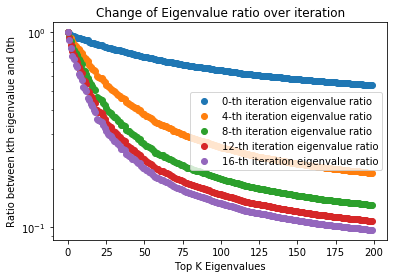

In [27]:


# for i in range(iters):
#     holder = MultiVector(true_initial_condition, 3)
#     curEigVal = allEigVal[i,:]
#     idx = curEigVal.argsort()[-3:][::-1]
#     for j in range(3):
    
#         holder[j].set_local(allEigVec[i][:,idx[j]])
        
    
    
#     nb.plot_eigenvectors(Vh, holder, mytitle="Eigenvector", which = [0,1,2])
numVec = 200
x = []
for i in range(numVec):
    x.append(i)
for j in range(0,17,4):
    curEigVal = allEigVal[j,:]
    curEigVal = sorted(curEigVal, reverse=True)
    base = curEigVal[0]
    for kk in range(numVec):
        curEigVal[kk] = curEigVal[kk] / abs(base)
    plt.plot(x, curEigVal[:numVec], 'o', label = str(j)+"-th iteration eigenvalue ratio")
plt.yscale("log")
plt.xlabel("Top K Eigenvalues")
plt.ylabel("Ratio between kth eigenvalue and 0th")
plt.title("Change of Eigenvalue ratio over iteration")
plt.legend()
plt.show()


[[ 0.000957    0.0009488   0.00092162 ...,  0.00040009  0.00040009
   0.00040009]
 [ 0.00148712  0.0014541   0.00141047 ...,  0.00040009  0.00040009
   0.00040009]
 [ 0.00198506  0.00191595  0.00186798 ...,  0.00040009  0.00040009
   0.00040008]
 ..., 
 [ 0.00582587  0.00525334  0.00473082 ...,  0.00040009  0.00040009
   0.00040009]
 [ 0.          0.          0.         ...,  0.          0.          0.        ]
 [ 0.          0.          0.         ...,  0.          0.          0.        ]]


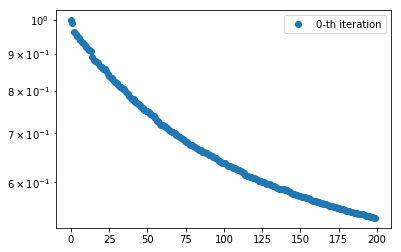

In [22]:
print(allEigVal)
k = 200
x = []
for i in range(k):                                                                                                                     
    x.append(i)
# # np.sort(allEigVal, key = lambda x: abs(x))
for it in range(iters):
    if it % 40 == 0:
        b = np.copy(allEigVal[it,:])
#         print(b)
        b = sorted(b, key = lambda x: -abs(x))
        base = b[0]
        for kk in range(len(b)):
            b[kk] = b[kk] / base
#         base = b[0]
        
#         for biter in range(len(b)):
            
#             b[biter] /= base
#         print("~~~~~~~~~~~~~~~~~~~~~~~~")
#         print(b)
        plt.plot(x, b[:k], 'o',label = str(it) + "-th iteration")
plt.yscale('log')
plt.legend()
plt.show()

## 9. Compute the MAP point

In [ ]:
H.misfit_only = False
        
solver = CGSolverSteihaug()
solver.set_operator(H)
solver.set_preconditioner( posterior.Hlr )
solver.parameters["print_level"] = 1
solver.parameters["rel_tolerance"] = 1e-6
solver.solve(a, -mg)
problem.solveFwd(u, [u,a,p], 1e-12)
 
total_cost, reg_cost, misfit_cost = problem.cost([u,a,p])
print("Total cost {0:5g}; Reg Cost {1:5g}; Misfit {2:5g}".format(total_cost, reg_cost, misfit_cost))
    
posterior.mean = a

plt.figure(figsize=(7.5,5))
nb.plot(dl.Function(Vh, a), mytitle="Initial Condition")
plt.show()

nb.show_solution(Vh, a, u, "Solution")

## 10. Prior and posterior pointwise variance fields

In [ ]:
compute_trace = True
if compute_trace:
    post_tr, prior_tr, corr_tr = posterior.trace(method="Estimator", tol=5e-2, min_iter=20, max_iter=2000)
    print("Posterior trace {0:5g}; Prior trace {1:5g}; Correction trace {2:5g}".format(post_tr, prior_tr, corr_tr))
post_pw_variance, pr_pw_variance, corr_pw_variance = posterior.pointwise_variance("Exact")

objs = [dl.Function(Vh, pr_pw_variance),
        dl.Function(Vh, post_pw_variance)]
mytitles = ["Prior Variance", "Posterior Variance"]
nb.multi1_plot(objs, mytitles, logscale=True)
plt.show()

## 11. Draw samples from the prior and posterior distributions

In [ ]:
nsamples = 5
noise = dl.Vector()
posterior.init_vector(noise,"noise")   
noise_size = get_local_size(noise)
s_prior = dl.Function(Vh, name="sample_prior")
s_post = dl.Function(Vh, name="sample_post")

pr_max =  2.5*math.sqrt( pr_pw_variance.max() ) + prior.mean.max()
pr_min = -2.5*math.sqrt( pr_pw_variance.min() ) + prior.mean.min()
ps_max =  2.5*math.sqrt( post_pw_variance.max() ) + posterior.mean.max()
ps_min = -2.5*math.sqrt( post_pw_variance.max() ) + posterior.mean.min()

for i in range(nsamples):
    noise.set_local( np.random.randn( noise_size ) )
    posterior.sample(noise, s_prior.vector(), s_post.vector())
    plt.figure(figsize=(15,5))
    nb.plot(s_prior, subplot_loc=121,mytitle="Prior sample", vmin=pr_min, vmax=pr_max)
    nb.plot(s_post, subplot_loc=122,mytitle="Posterior sample", vmin=ps_min, vmax=ps_max)
    plt.show()

Copyright (c) 2016-2018, The University of Texas at Austin & University of California, Merced.
All Rights reserved.
See file COPYRIGHT for details.

This file is part of the hIPPYlib library. For more information and source code
availability see https://hippylib.github.io.

hIPPYlib is free software; you can redistribute it and/or modify it under the terms of the GNU General Public License (as published by the Free Software Foundation) version 2.0 dated June 1991.